## Making SOM cutouts

In [1]:
import os
os.chdir('../')
from scripts.analysis_tools_cython import import_XRPlightcurve, processing, import_lightcurve, normalise_flux
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data, _ = import_lightcurve("betapic/hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits", return_type='pandas')
#data = data['TIME','PDCSAP_FLUX','QUALITY','PDCSAP_FLUX_ERR']
data.head()

,TIME,PDCSAP_FLUX,QUALITY,PDCSAP_FLUX_ERR
0,1468.304154,5507612.0,0,64.862846
1,1468.324987,5507246.5,0,64.860832
2,1468.345820,5507478.5,0,64.863037
3,1468.366654,5508482.0,0,64.867645
4,1468.408320,5507866.5,0,64.860580


In [3]:
results, _ = processing(data,method='median')

In [4]:
results = results.split()

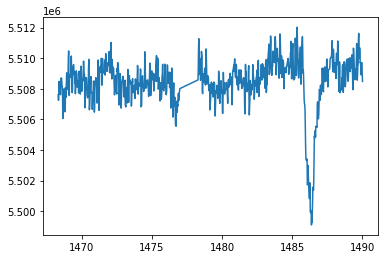

In [5]:
plt.plot(data['TIME'],data['PDCSAP_FLUX'])

In [6]:
time = float(results[4])
time

1486.26239654

1 day == 48 cadences
4 days = 192 cadences
2 days = 96 cadences

In [7]:
#som_cut1 = time - 

In [8]:
data.TIME[data.TIME.loc[data.TIME == time]]
#- 5 : data.time.loc[data.time == injected_time].index[0]
#+ 5

Series([], Name: TIME, dtype: float64)

In [9]:
#data.time[data.time.loc == time]

In [10]:
data.iloc[(data['TIME']-time).abs().argsort()[:1]]['TIME'].values[0]

1486.262396535327

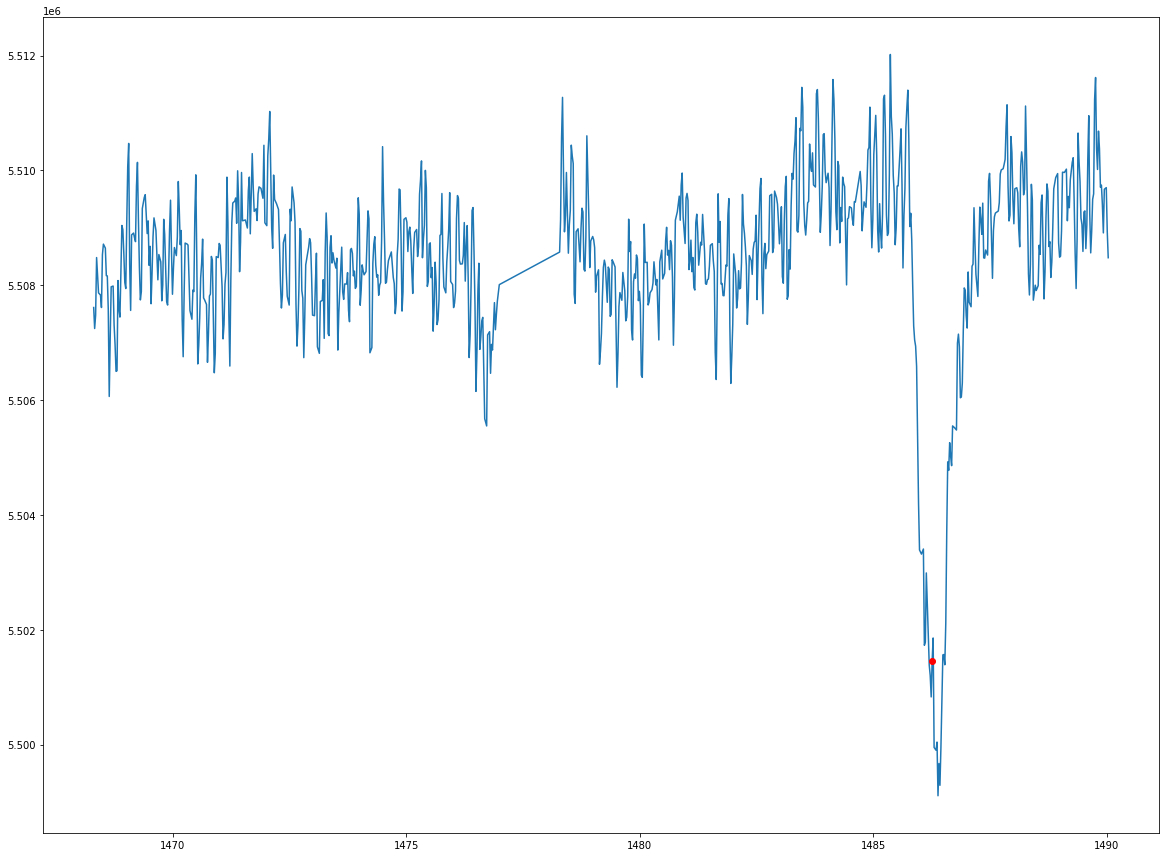

In [11]:
plt.figure(figsize=(20,15))
plt.plot(data['TIME'],data['PDCSAP_FLUX'])
plt.plot(data.iloc[(data['TIME']-time).abs().argsort()[:1]]['TIME'].values[0],data.iloc[(data['TIME']-time).abs().argsort()[:1]]['PDCSAP_FLUX'].values[0],'ro')


In [12]:
som_cutout = data[data.iloc[(data['TIME']-time).abs().argsort()[:1]]['TIME'].index[0] - 120: data.iloc[(data['TIME']-time).abs().argsort()[:1]]['TIME'].index[0] + 120]
som_cutout


,TIME,PDCSAP_FLUX,QUALITY,PDCSAP_FLUX_ERR
670,1483.741585,5509728.5,0,64.863976
671,1483.762418,5509710.5,0,64.867516
672,1483.783251,5511334.0,0,64.876495
673,1483.804084,5511408.0,0,64.877350
674,1483.824918,5510903.5,0,64.872627
...,...,...,...,...
905,1488.679036,5508228.0,0,64.860550
906,1488.699869,5509171.5,0,64.865807
907,1488.720702,5509764.5,0,64.868568
908,1488.741535,5509636.5,0,64.867119


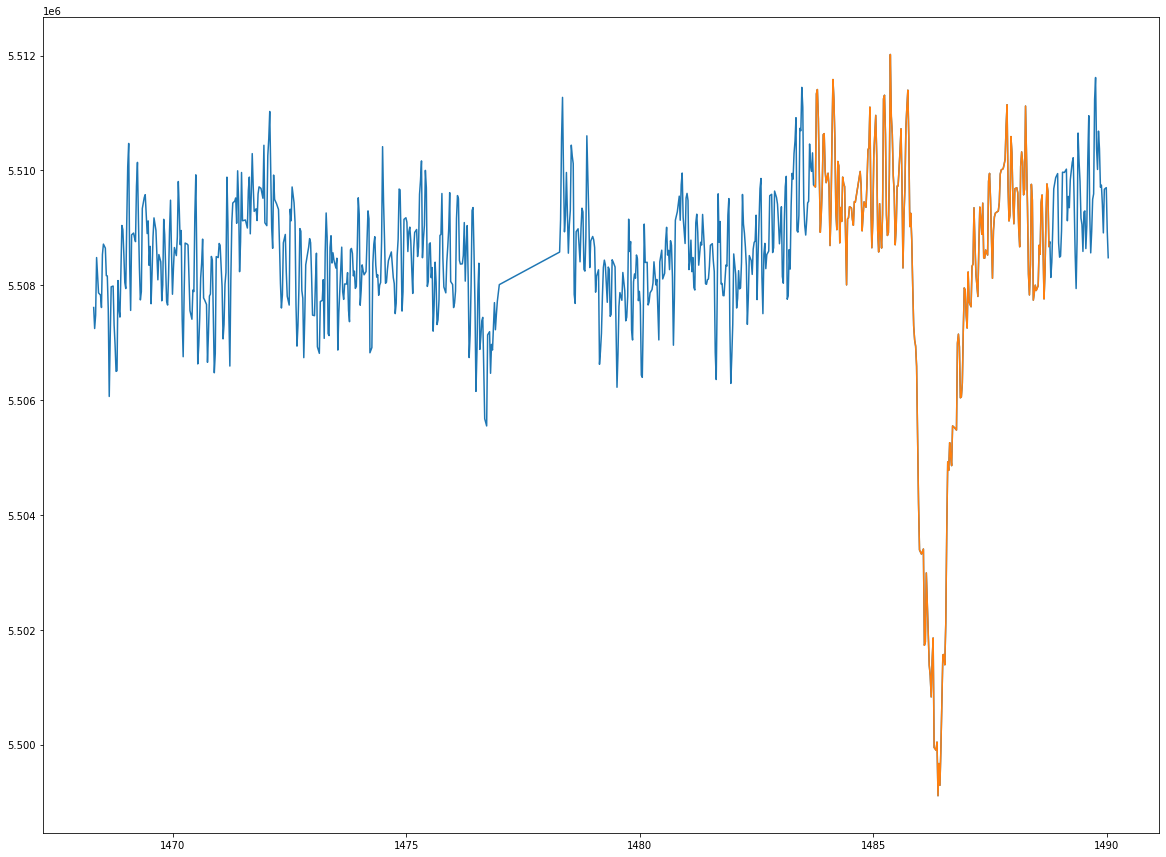

In [13]:
plt.figure(figsize=(20,15))
plt.plot(data['TIME'],data['PDCSAP_FLUX'])
plt.plot(som_cutout.TIME, som_cutout.PDCSAP_FLUX)

---

**We want to test if the extrapolation here will work**

In [14]:
from scipy.interpolate import interp1d

In [15]:
def create_som_cutout_test(table, min_T, half_cutout_length=120):
    """creates cutout of lightcurve to prepare for SOM. The SOM requires all lightcurves to be the same length.

    inputs:
    :table (pd.DataFrame or astropy.table): The input lightcurve data from which the cutout will be created. If the table is in an astropy format, it will be converted.
    :min_T (numeric): the time which `processing` output
    :half_cutout_length (optional, numeric): the size of half the window desired in the number of data points.
    
    returns:
    :cutout (pd.DataFrame): a sliced lightcurve centered around the minimum time value with extrapolated data points if necessary.
    """

    if not isinstance(table, pd.DataFrame):
        table = table.to_pandas()

    time_values = table["time"].values
    min_time = np.min(time_values)
    max_time = np.max(time_values)

    target_min_index = np.searchsorted(time_values, min_T) - half_cutout_length
    target_max_index = np.searchsorted(time_values, min_T) + half_cutout_length

    if target_min_index < 0 or target_max_index >= len(time_values):
        # Extrapolation is required
        
        # Interpolate the existing data
        interpolator = interp1d(time_values, table.values.T, fill_value="extrapolate")
        
        # Generate the extrapolated time values
        extrapolated_times = np.concatenate((
            np.arange(time_values[0], time_values[target_min_index], -1),  # Extrapolate before min_T
            np.arange(time_values[target_max_index], time_values[-1] + 1)   # Extrapolate after min_T
        ))
        
        # Interpolate the extrapolated data
        extrapolated_data = interpolator(extrapolated_times).T
        
        # Combine the extrapolated and existing data
        combined_data = np.concatenate((extrapolated_data, table.values))
        
        # Create a new DataFrame with the combined data
        column_names = table.columns
        combined_table = pd.DataFrame(combined_data, columns=column_names)
        
        # Sort the DataFrame by the time column
        combined_table.sort_values("time", inplace=True)
        
        # Extract the cutout around the min_T value
        cutout = combined_table.iloc[target_min_index:target_max_index + 1]
    else:
        # No extrapolation needed, extract the cutout directly
        cutout = table.iloc[target_min_index:target_max_index + 1]
    
    return cutout

## Testing data extrapolation

In [16]:
from scripts.injection_test_utils import inject_lightcurve
from scripts.som_utils import *
import pandas as pd

In [17]:
data, lc_info = import_XRPlightcurve("/storage/astro2/phrdhx/tesslcs/tesslcs_sector_7_104/2_min_cadence_targets/tesslc_270577175.pkl",sector=6)
data = data['time','corrected flux','quality','flux error']

In [18]:
result_str, arrays = processing(data,lc_info=lc_info,method='median')

In [19]:
data_to_cut = pd.DataFrame(data=arrays).T
data_to_cut.columns = ['time','flux','quality','flux error']


In [20]:
def inject_comet(flux, time, depth, injected_time):
    return flux * (
        1 - comet_curve(time, depth, injected_time,0.1,0.5 )
    )

In [21]:
depth = 10 ** np.random.uniform(-3, -2)
new_flux = inject_lightcurve(data['corrected flux'],data['time'],depth=depth, injected_time=1510)

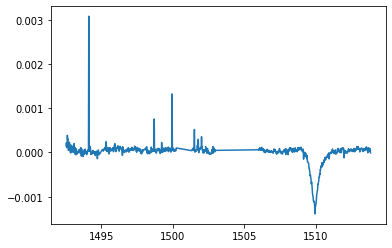

In [22]:
plt.plot(data['time'], normalise_flux(new_flux))

In [23]:
flux_to_som = normalise_flux(new_flux)

In [27]:
test = pd.DataFrame(data=[data['time'],flux_to_som,data['quality'],data['flux error']]).T
test.columns = ['time','flux','quality','flux error']
results2, _ = processing(test,method='median')
results2 = results2.split()
min_T = float(results2[4])

In [33]:
test[test.iloc[(test["time"] - min_T).abs().argsort()[:1]]["time"].index[0]- 120 : test.iloc[(test["time"] - min_T).abs().argsort()[:1]]["time"].index[0]+ 120]

,time,flux,quality,flux error
486,1507.449610,0.000041,0.0,21.117648
487,1507.470443,0.000088,0.0,21.118144
488,1507.491276,0.000026,0.0,21.117313
489,1507.512109,0.000044,0.0,21.117567
490,1507.532942,0.000017,0.0,21.117381
...,...,...,...,...
721,1512.449516,0.000060,0.0,21.113803
722,1512.470349,0.000069,0.0,21.114589
723,1512.491182,0.000059,0.0,21.113965
724,1512.512015,0.000075,0.0,21.113670


In [32]:
som_cutout = test[test.iloc[(data['time']-min_T).abs().argsort()[:1]]['time'].index[0] - 120: test.iloc[(test['time']-min_T).abs().argsort()[:1]]['time'].index[0] + 120]


AttributeError: 'Column' object has no attribute 'abs'

In [29]:
np.savez(time=som_cutout.TIME,flux=som_cutout.PDCSAP_FLUX,quality=som_cutout.QUALITY,flux_err=som_cutout.PDCSAP_FLUX_ERR)

In [17]:
import os

In [18]:
data, _ = import_lightcurve("betapic/hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits")

In [19]:
results, data_arr = processing(data,method='median')

In [20]:
import pandas as pd

In [21]:
test = pd.DataFrame(data_arr).T

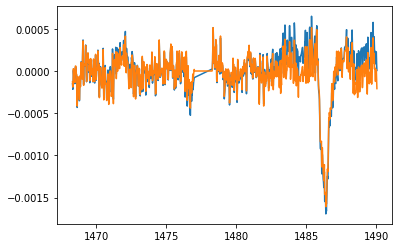

In [22]:
plt.plot(data['TIME'],normalise_flux(data['PDCSAP_FLUX']))
plt.plot(test[0],test[1])